In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:06, 26265666.51it/s]                               


Files already downloaded and verified


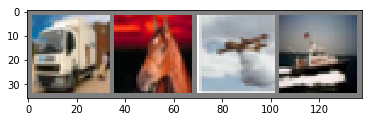

truck horse plane  ship


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import numpy as np
import math
import scipy.special as ss
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def CP(Y, tol=0.01):

    """
    INITIALIZATION
    Y - input tensor (complete)
    tol - lower band change tolerance for convergence dection
    init = ml - Apply SVD to Y and initialize factor matrices

    maxiters - maximum number of iterations
    """

    """
    OUTPUT
    LB_res - lower bounds on each iterations
    """

    init = 'ml'
    dimY = np.shape(Y)
    N = len(dimY)
    nObs = np.prod(dimY)
    maxiters = 100
  #  tol = 1e-4
    LB_res = []
    conv_res =  []
    
    X_true = np.array([])
    R = max(dimY)
    
    a_gamma0     = 1e-6
    b_gamma0     = 1e-6
    a_beta0      = 1e-6
    b_beta0      = 1e-6
    a_alpha0     = 1e-6
    b_alpha0    = 1e-6

    eps = 1e-18
    initVar = 1
    LB = [0]
    
    gammas = (a_gamma0+eps)/(b_gamma0+eps)*np.ones((R,1))
  #  print(gammas)
    beta = (a_beta0+eps)/(b_beta0+eps)
    alphas = 1 / initVar *np.ones(dimY)*((a_alpha0+eps)/(b_alpha0+eps))
    #print(alphas)
    
    
    E = 1 / np.sqrt(alphas)*np.random.randn(*dimY)
  
    Sigma_E = 1/alphas * np.ones(dimY)
    
    
    """
    Apply SVD to Y and initialize factor matrices
    """
    if init == 'ml':
       
        Z = [0]
        ZSigma = [0]
        for n in range(N):
        #i = 0
        #for n in dimY:
            if n == 0:
            #if i == 0:
                ZSigma[0] = np.diag(1/gammas)
               # rest = nObs / dimY[n] #/ dimY[n+1]
               # dim = dimY[n+1]
            else:
                ZSigma.append(np.diag(1/gammas))
                
               # dim = dimY[n-1]
           # print(type(Y[n]), type(dim), type(rest))
            rest = nObs / dimY[n] 
            U, S, V = np.linalg.svd(np.swapaxes(Y, n, 0).reshape(dimY[n], int(rest)))
            #print(U, S)
            #print(U.shape, S.shape, V.shape)
            #S = S.reshape(len(S), 1)
            S = np.diag(S)
            dvar = np.sqrt(np.sum(Y ** 2)/ nObs)
            
           # print(U, S, V)
            if R <= U.shape[1]:
                if n == 0:
                   # print(U.shape, S.shape)
                    #print(U[:,:R].shape, S[:R, :R].shape)
                    Z[0] = U[:,:R] @ np.sqrt(S[:R,:R])
                else:
                    Z.append(U[:,:R] @ np.sqrt(S[:R,:R]))
                #print(0)
                
                    
            else:
                if n == 0:
                    #Z[0] = [U@np.sqrt(np.diag(S)), np.random.randn(dimY[n],R - U.shape[1]) * dvar]
                    Z[0] = np.hstack((U@np.sqrt(S), np.random.randn(dimY[n],R - U.shape[1]) * dvar))
                    #Z[0] = U@np.sqrt(S)
                else:
                    #Z.append([U@np.sqrt(np.diag(S)), np.random.randn(dimY[n],R - U.shape[1]) * dvar])
                 #   print(U@np.sqrt(S))
                   # print(np.ravel(np.random.randn(dimY[n],R - U.shape[1]) * dvar))
                   # print(U@np.sqrt(S))
                    Z.append(np.hstack((U@np.sqrt(S), np.random.randn(dimY[n],R - U.shape[1]) * dvar)))
                    #Z.append(U@np.sqrt(S))
         #   print(Z[n])
                    
   # print(ZSigma)
  #  print(Z)
    
    """
    Model learning
    """
    EZZT = [0]
    
   # print(np.array(ZSigma))
    #ZSigma = np.array(ZSigma)
    #print(Z, dimY, ZSigma)
  #  for i in range(len(Z)):
   #     Z[i] = np.array(Z[i])
  #  print(Z)
    #Z = np.array(Z)
 #   print(Z.shape, np.array(ZSigma).shape)
    EZZT[0] = np.array(Z[0]).T @ np.array(Z[0]) + dimY[0] * np.array(ZSigma)[0]
    for n in range(1,N):
        EZZT.append(Z[0].T @ Z[0] + dimY[0] * np.array(ZSigma)[0])
        
    for i in range(maxiters):
        """
        Update factor matrices
        """
        Aw = np.diag(np.diag(gammas))
        for n in range(N):
            """
            compute E(Z_{\n}^{T} Z_{\n})
            """
            ENZZT = np.ones((R,R))
            for m in range(N):
                if m != n:
                    ENZZT = ENZZT * EZZT[m]
            """
            compute E(Z_{\n})*(Y-E)
            khatri-rao product
            """
            orig = np.linspace(0,N-1,N,dtype=int)
            #print(orig)
            inds = np.delete(orig, n)
            inds = np.flip(inds)
            #print(Z, len(Z))
           # print(inds)
            if n != (N-1):
                A = Z[N-1]
            else:
                A = Z[N-2]
            inds = np.delete(inds, 0)    
            #print(A)
           # print(Z)
            sh = A.shape[1]
            
          #  print(Z.shape)
        #    print(inds)
            for j in inds:
               # print(Z.shape)
                #print(inds[j])
                
                    
                B = Z[j]
                for col in range(sh):
                    kron_col = np.kron(A[:,col],B[:,col])
                    kron_col = kron_col[np.newaxis, :].T
                    if col > 0:
                        khatri = np.hstack((khatri, kron_col))
                    else:
                        khatri = kron_col
                  #  print(khatri)
                A = khatri
               # print(A)
            
            rest = nObs / dimY[n]
            tenmat = np.swapaxes(Y-E,int(n),0).reshape(int(dimY[n]), int(rest))
         #   print(A.shape, tenmat.shape)
            FslashY = A.T @ tenmat.T
          #  print(tenmat.shape)
            """
            compute posterior distribution
            """
          #  if R != 7:
           #     print(beta, ENZZT, Aw)
            #print(ENZZT.shape)
            ZSigma[n] = np.linalg.inv(beta * ENZZT + Aw)
            #print(ZSigma[n].shape)
            
            
            #print(ZSigma[n])
            
          #  print(np.array(ZSigma)[n].shape, FslashY.shape)
            
           # print(ZSigma[0].shape, ZSigma[1].shape, FslashY.shape)
            try:
                Z[n] = (beta * np.array(ZSigma)[n] @ FslashY).T
            except ValueError:
                #print(np.hstack((ZSigma[0], ZSigma[1].reshape(-1,1))).shape)
               # Z[n] = (beta * np.vstack((ZSigma[0], ZSigma[1].reshape(1,-1)))[n] @ FslashY).T
                Z[n] = (beta * ZSigma[n] @ FslashY).T
                #print(Z[n])
          #  print(Z[n].shape, ZSigma[n].shape)
            EZZT[n] = Z[n].T @ Z[n] + dimY[n] * ZSigma[n]
          #  print(Z[n])
            
        
     #   print(len(Z))
        """
        reshape / cut / add zeros
        """
        X = Z[0]
    #    print(X)
        for j in range(1,len(Z)):
     #       print(Z[j])
            X = np.vstack((X,Z[j]))
       # X = X.reshape(*dimY)
        X = np.ravel(X)
      #  np.random.shuffle(X)
        X = X[:nObs]
       # np.random.shuffle(np.ravel(X))[:nObs]
        #print(Z)
        #print(nObs)
        try:
            X = X.reshape(*dimY)
          #  print('Yes')
        except ValueError:
            X = np.ravel(X)
          #  add = np.random.randn(nObs-len(X))
            add = np.zeros(nObs-len(X))
            X = np.hstack((X, add))
            X = X.reshape(*dimY)
      #  X = np.array(Z).reshape(*dimY)
        #print(X.shape)
        """
        Update hyperparameters gamma
        """
        
        a_gammaN = (0.5 * np.sum(dimY) + a_gamma0) * np.ones((R,1))
        b_gammaN = 0
        for n in range(N):
            b_gammaN = b_gammaN + np.diag(Z[n].T @ Z[n]) + dimY[n] * np.diag(ZSigma[n])
        b_gammaN = b_gamma0 + 0.5*b_gammaN
        gammas = a_gammaN / b_gammaN
        
        """
        update noise beta
        """
        EX2 = np.ones((R,R))
        for n in range(N):
            EX2 = EX2 * EZZT[n]
        
        EX2 = np.sum(EX2)
        EE2 = np.sum((E ** 2 + Sigma_E))
        err = np.ravel(Y) @ np.ravel(Y)[np.newaxis, :].T - 2*np.ravel(Y) @ np.ravel(X)[np.newaxis, :].T - 2 * np.ravel(Y) @ np.ravel(E)[np.newaxis, :].T + 2 * np.ravel(X) @ np.ravel(E)[np.newaxis, :].T + EX2 + EE2
        
        a_betaN = a_beta0 + 0.5 * nObs
        b_betaN = b_beta0 + 0.5 * err
        beta = a_betaN / b_betaN
        
     #   print(X.shape)
        """
        Update sparse matrix E
        """
        
        Sigma_E = 1 / (alphas + beta)
        E = beta * (Y-X) * Sigma_E
        
        """
        Update the alphas
        """
        inf_flag = 1
        if inf_flag == 1:
            a_alphaN = a_alpha0 + 0.5
            b_alphaN = b_alpha0 + 0.5 * (E ** 2 + Sigma_E)
            alphas = a_alphaN / b_alphaN
        
        
        """
        Lower bound
        """
        temp1 = -0.5*nObs *np.log(2*math.pi)+0.5*nObs*(ss.psi(a_betaN)-np.log(b_betaN))-0.5*(a_betaN/b_betaN)*err
      #  print(np.sum(ZSigma, 2))
        temp2 = 0
       # print(np.diag(np.diag(gammas)))
        for n in range(N):
            temp2=temp2-0.5*R*dimY[n]*np.log(2*math.pi)+0.5*dimY[n]*np.sum(ss.psi(a_gammaN)-np.log(b_gammaN))-0.5*np.trace(np.diag(np.diag(gammas))*np.sum(ZSigma[n],1))-0.5*np.trace(np.diag(np.diag(gammas))@Z[n].T@Z[n])
            
        temp3 = np.sum(-np.log(math.gamma(a_gamma0)) + a_gamma0*np.log(b_gamma0) -  b_gamma0*(a_gammaN/b_gammaN) + (a_gamma0-1)*(ss.psi(a_gammaN)-np.log(b_gammaN)))
        temp4 = -np.log(math.gamma(a_beta0)) + a_beta0*np.log(b_beta0) + (a_beta0-1)*(ss.psi(a_betaN)-np.log(b_betaN)) - b_beta0*(a_betaN/b_betaN)
        temp5=0.5*R*np.sum(dimY)*(1+np.log(2*math.pi))
        for n in range(N):
            temp5 += dimY[n]*0.5*np.log(np.linalg.det(ZSigma[n]))
       # print(a_gammaN)
        #print(math.gamma(a_gammaN))
        temp6 = np.sum(np.log(math.gamma(a_gammaN[0])) - (a_gammaN-1)*ss.psi(a_gammaN) -np.log(b_gammaN) + a_gammaN)
        temp7 = np.log(math.gamma(a_betaN)) - (a_betaN-1)*ss.psi(a_betaN) -np.log(b_betaN) + a_betaN
        temp = ss.psi(a_alphaN) - np.log(b_alphaN)
        temp8 = -0.5*nObs*np.log(2*math.pi) + 0.5*np.sum(temp) - 0.5*(np.ravel(E)**2 + np.ravel(Sigma_E))@np.ravel(alphas)[np.newaxis, :].T
        temp9 = -nObs*np.log(math.gamma(a_alpha0)) + nObs*a_alpha0*np.log(b_alpha0) + np.sum((a_alpha0-1)*np.ravel(temp) - b_alpha0*np.ravel(alphas))
        temp10 = 0.5*np.sum(np.log(Sigma_E)) + 0.5*nObs*(1+np.log(2*math.pi))
        temp11 = np.log(math.gamma(a_alphaN)) - (a_alphaN-1)*ss.psi(a_alphaN) -np.log(b_alphaN) + a_alphaN
        temp11 = np.sum(temp11)
       # print(LB)
        if i == 0:
            LB[0] = temp1 + temp2 + temp3 + temp4 + temp5 + temp6 + temp7 + temp8 + temp9 + temp10 + temp11
        else:
            LB.append(temp1 + temp2 + temp3 + temp4 + temp5 + temp6 + temp7 + temp8 + temp9 + temp10 + temp11)
     #   print(temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8, temp9, temp10, temp11)
        
        
        
        
        """
        update hyperparameters
        """
        if i>5:
            aMean = np.mean(alphas)
           # print(aMean)
            bMean = np.mean(ss.psi(a_alphaN) - np.log(b_alphaN))
            def ngLB(x):
                return np.log(abs(math.gamma(abs(x))))-x*np.log(abs(x/aMean))-(x-1)*bMean+x
            #print(ngLB(0))
            a_alpha0 = minimize_scalar(ngLB, bracket=(1e-20, 5)).x
           # print(a_alpha0)
            
            b_alpha0 = a_alpha0/aMean
            
            
        """
        Prune irrelevant dimensions
        """
      
        #Zall = cell2mat(Z);
        #print(len(Z))
        #print(np.array(Z).shape)
        Zall = np.array(Z).reshape(-1, R)
        #print(Zall.shape)
        comPower = np.diag(Zall.T @ Zall)
        #print(comPower)
        #print(comPower.shape)
        comTol = np.sum(dimY)* (2e-20 * np.linalg.norm(Zall,ord='fro'))
        #print(comPower, comTol)
        rankest = np.sum(np.where(comPower> comTol ,1,0))
       # print(rankest)
       
        if rankest==0:       
            print('Rank becomes 0')
        if rankest <= 2:
            break
        if i >=2:
            if R > rankest:
                indices = np.where(comPower> comTol ,1,0)
                #gammas = np.where(indices == 1, gammas, 0)
                gammas = gammas[indices == 1]
                #print(gammas)
                for n in range(N):
                    Z[n] = Z[n][:,indices == 1]
                
                    ZSigma[n] = ZSigma[n][indices == 1,indices == 1]
                    EZZT[n] = EZZT[n][indices == 1,indices == 1]
                  #  print(Z[n].shape, ZSigma[n].shape)
                R = rankest
                
               # print('R = {}'.format(R))
               # print(Z, ZSigma, EZZT, R)
      

        
        
            
        """
        Display progress
        """
        if i > 2:
            converge = -1*((LB[i] - LB[i-1])/LB[1])
        else:
            converge = np.inf
            
        
    
        err = np.ravel(X) #- np.ravel(X_true)
        err = err ** 2
        
        #print('i {}: mse = {}, LB = {}, conv = {}'.format(i, np.mean(err), LB[i], converge))
        LB_res.append(LB[i])
        """
        Convergence check
        """

        if ((i > 5) and (abs(converge) <  tol)):
           # print('Converged')
            break
            
            
    #return LB_res
    #return Z, ZSigma, gammas, E, Sigma_E, beta, max(LB)
    return ZSigma[0]

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #self.fc2 = nn.Linear(120, 10)
       # self.fc3 = nn.Linear(10, 10)
        weights = np.random.randn(10, 10)
        self.compressed = torch.from_numpy(CP(weights))
        self.fc2 = nn.Linear(120,self.compressed.size()[0])
        self.fc3 = nn.Linear(self.compressed.size()[0], self.compressed.size()[1])
        self.fc3.weight = torch.nn.Parameter(self.compressed.float())
        self.fc4 = nn.Linear(self.compressed.size()[1], 10)
       
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #print(self.compressed)
        #x = torch.mm(x, self.compressed.float())
        x = self.fc4(x)
        return x


net = Net()

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [82]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(inputs)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
       # print(i)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.307
[1,  4000] loss: 2.304
[1,  6000] loss: 2.304
[1,  8000] loss: 2.303
[1, 10000] loss: 2.290
[1, 12000] loss: 2.148
[2,  2000] loss: 1.953
[2,  4000] loss: 1.862
[2,  6000] loss: 1.803
[2,  8000] loss: 1.777
[2, 10000] loss: 1.737
[2, 12000] loss: 1.722
Finished Training


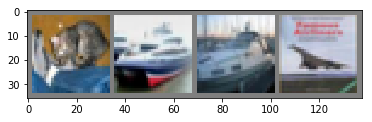

GroundTruth:    cat  ship  ship plane


In [83]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = net(images)

In [85]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   bird  ship plane plane


In [86]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 30 %
